<a href="https://colab.research.google.com/github/giakomorssi/Deloitte_Project/blob/main/03_FraudDetection_noOS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the Data

In [46]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# Change Colab runtime to GPU
import os
os.environ['COLAB_TPU_ADDR'] = ''
os.environ['COLAB_GPU_ALLOC'] = '1'
os.environ['COLAB_GPU'] = '1'
print("Runtime switched to GPU")

import tensorflow as tf

if not tf.test.gpu_device_name():
    print('GPU device not found')
else:
    print('GPU device found:', tf.test.gpu_device_name())

# This code sets the runtime to use the GPU if available
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

pd.set_option('display.max_columns', None)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Runtime switched to GPU
GPU device not found
Please install GPU version of TF


In [47]:
df = pd.read_csv('/content/drive/MyDrive/University/Deloitte/SupplyChainDataset.csv', encoding = 'latin-1')

# Cleaning

In [48]:
# Remove Na and Empty Columns

df.drop(['Product Description', 'Order Zipcode', 'Order Profit Per Order', 'Customer Email', 'Customer Password'], axis = 1, inplace = True) 
df.dropna(inplace = True) #remove 1 missing value

## Category Column


1. **COMPLETE:** The order or transaction has been successfully fulfilled and completed.
2. **PENDING**: The order or transaction is still in progress and has not yet been completed.
3. **CLOSED**: The order or transaction has been closed or terminated for some reason, such as a return or cancellation.
4. **PENDING_PAYMENT**: The order or transaction is awaiting payment before it can be processed.
5. **CANCELED**: The order or transaction has been canceled by the customer or the seller for some reason.
6. **PROCESSING**: The order or transaction is being processed by the seller or merchant.
7. **SUSPECTED_FRAUD**: The order or transaction is under review due to suspected fraudulent activity.
8. **ON_HOLD**: The order or transaction has been placed on hold for some reason, such as a delay in shipping or a credit hold.
9. **PAYMENT_REVIEW**: The payment for the order or transaction is under review by the payment processor or financial institution.

In [49]:
# Regular -> Complete, Pending, Pending_Payment, Processing
# Suspected -> Closed, Canceled, On_Hold, Payment_Review
# Fraud -> Suspected_Fraud

# define dictionaries to map status values to categories
regular_dict = {'COMPLETE': 'Regular', 'PENDING': 'Regular', 'PENDING_PAYMENT': 'Regular', 'PROCESSING': 'Regular'}
suspected_dict = {'CLOSED': 'Suspected', 'CANCELED': 'Suspected', 'ON_HOLD': 'Suspected', 'PAYMENT_REVIEW': 'Suspected'}
fraud_dict = {'SUSPECTED_FRAUD': 'Fraud'}

# create a function to map status values to categories
def map_category(status):
    if status in regular_dict:
        return regular_dict[status]
    elif status in suspected_dict:
        return suspected_dict[status]
    elif status in fraud_dict:
        return fraud_dict[status]
    else:
        return 'Unknown'

# apply the function to the 'status' column to create a new 'category' column
df['Category'] = df['Order Status'].apply(map_category)

print('Regular: ', len([x for x in df['Category'] if x == 'Regular']), '\n')
print('Suspected: ', len([x for x in df['Category'] if x == 'Suspected']), '\n')
print('Fraud: ', len([x for x in df['Category'] if x == 'Fraud']))

Regular:  141442 

Suspected:  35004 

Fraud:  4062


## Encoding

In [50]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# Type
df['Type'] = le.fit_transform(df['Type'])

# Delivery Status
df['Delivery Status'] = le.fit_transform(df['Delivery Status'])

# Customer Segment
df['Customer Segment'] = le.fit_transform(df['Customer Segment'])

# Order Status
df['Order Status'] = le.fit_transform(df['Order Status'])

# Shipping Mode
df['Shipping Mode'] = le.fit_transform(df['Shipping Mode'])

# Category
df['Category'] = le.fit_transform(df['Category'])

In [51]:
from sklearn.model_selection import train_test_split

df.drop(['Category Name', 'Customer City',
       'Customer Country', 'Customer Fname', 'Customer Id', 'Customer Lname',
       'Customer State',	'Customer Street', 'Department Name', 
       'Market', 'Order City', 'Order Country', 'Order Customer Id', 'Order Region',	
       'Order State', 'Product Image',	'Product Name',
       'shipping date (DateOrders)', 'order date (DateOrders)', 'Category Id', 'Customer Zipcode', 
       'Department Id', 'Latitude',	'Longitude', 'Order Id',	'Order Item Cardprod Id',
       'Order Item Id', 'Product Card Id', 'Product Category Id'], axis = 1, inplace = True)

df.to_csv('/content/drive/MyDrive/University/Deloitte/df_number.csv', index = False)

In [52]:
from sklearn.model_selection import train_test_split  

df.drop(['Order Status'], axis=1, inplace=True)

X = df.drop(['Category'], axis=1) #Not scaled
y = df['Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True)

In [53]:
from sklearn.preprocessing import StandardScaler

s = StandardScaler()

X_train = s.fit_transform(X_train)
X_test = s.transform(X_test)

# PCA

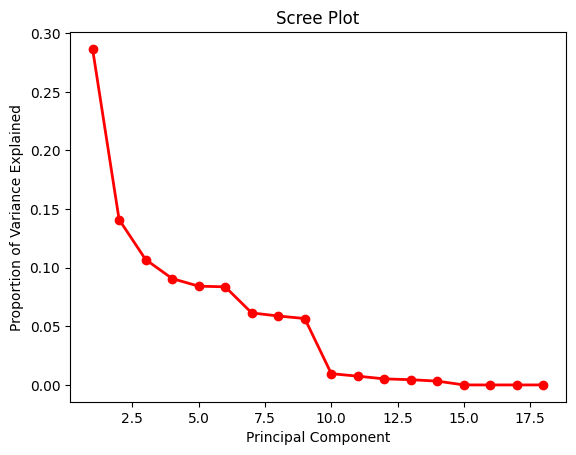


 Number of components to keep: 9


In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Initialize a PCA object
pca = PCA()

# Fit the PCA object to the data
pca.fit(X_train)

# Create a scree plot
num_components = len(pca.explained_variance_ratio_)
plt.plot(np.arange(1, num_components+1), pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

# Determine the number of components to keep
variance_threshold = 0.95
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
num_components_to_keep = np.argmax(cumulative_variance_ratio >= variance_threshold) + 1

print(f'\n Number of components to keep: {num_components_to_keep}')

# Transform the data using the chosen number of components
pca = PCA(n_components=num_components_to_keep)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

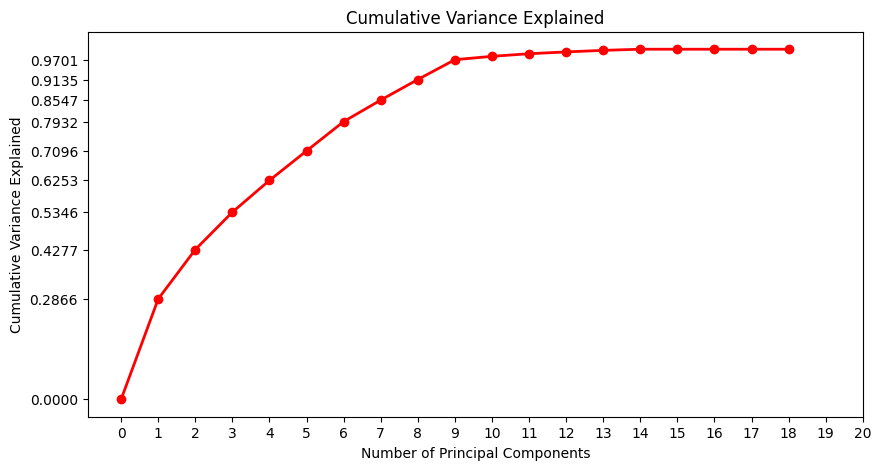

In [55]:
# Plot the cumulative variance explained

fig = plt.figure(figsize=(10, 5))

cum = np.insert(cumulative_variance_ratio, 0, 0)
ylab = np.insert(np.cumsum(pca.explained_variance_ratio_), 0, 0)

plt.plot(cum, 'ro-', linewidth=2)
plt.title('Cumulative Variance Explained')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.yticks(ylab)
plt.xticks(np.arange(0, 21))
plt.show()

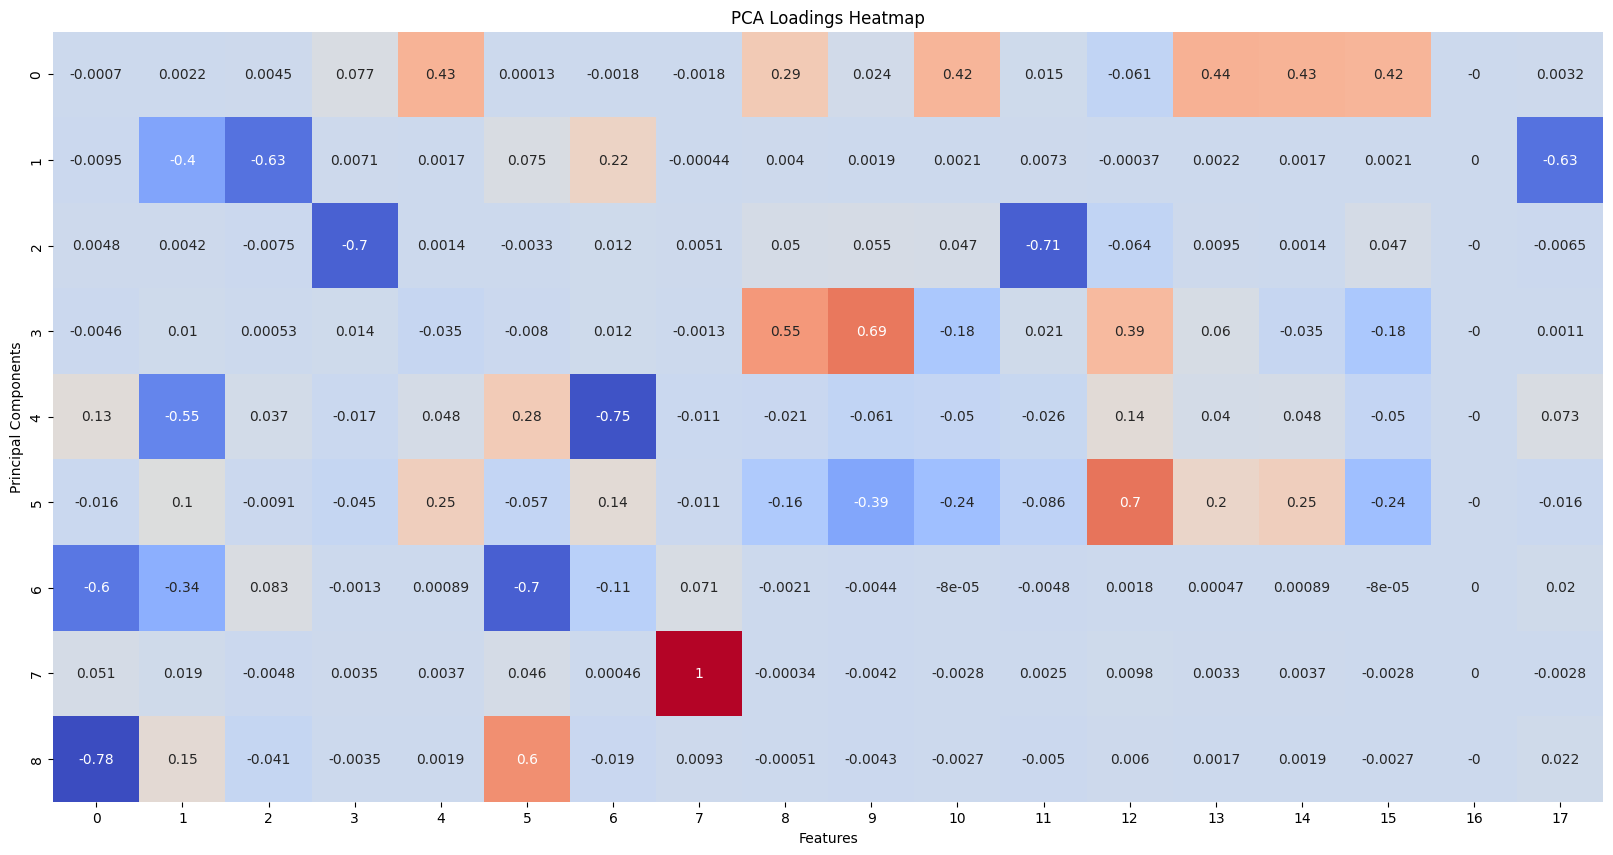

In [56]:
import seaborn as sns

# Heatmap loadings
fig = plt.figure(figsize=(20, 10))
sns.heatmap(pca.components_, cmap='coolwarm', annot=True, cbar=False)
plt.xlabel('Features')
plt.ylabel('Principal Components')
plt.title('PCA Loadings Heatmap')
plt.show()

In [57]:
# Get the principal components as vectors in the original feature space
pc_vectors = pca.components_

# Get the names of the original columns
column_names = X.columns

# Print the names of the columns chosen as principal components
num_pcs = pc_vectors.shape[0]
for i in range(num_pcs):
    pc_name = f'PC{i+1}'
    pc_loadings = pc_vectors[i]
    relevant_columns = column_names[np.abs(pc_loadings) >= 0.40]
    print(f'{pc_name}:\n {relevant_columns.tolist()}, \n {pc_loadings[np.abs(pc_loadings) >= 0.40]} \n ')

PC1:
 ['Sales per customer', 'Order Item Product Price', 'Sales', 'Order Item Total', 'Product Price'], 
 [0.42857865 0.41621971 0.43671697 0.42857865 0.41621971] 
 
PC2:
 ['Days for shipment (scheduled)', 'Shipping Mode'], 
 [-0.6271118  -0.62729829] 
 
PC3:
 ['Benefit per order', 'Order Item Profit Ratio'], 
 [-0.69784485 -0.70605077] 
 
PC4:
 ['Order Item Discount', 'Order Item Discount Rate'], 
 [0.55390846 0.6861393 ] 
 
PC5:
 ['Days for shipping (real)', 'Late_delivery_risk'], 
 [-0.54527527 -0.75018322] 
 
PC6:
 ['Order Item Quantity'], 
 [0.70020448] 
 
PC7:
 ['Type', 'Delivery Status'], 
 [-0.60450647 -0.7008987 ] 
 
PC8:
 ['Customer Segment'], 
 [0.99732419] 
 
PC9:
 ['Type', 'Delivery Status'], 
 [-0.78306126  0.6008786 ] 
 


# Models

In [58]:
import pandas as pd
import numpy as np
import pickle

# Split the dataset into features and target
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)
y_train = np.ravel(y_train)

print(X_train.shape, y_train.shape)
print(type(X), type(y))

(144406, 9) (144406,)
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>


In [59]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(class_weight='balanced', max_depth = 4)
'''
 Fraud Recall: 0.9819, std: 0.0139, Under 0.7: 0, []
 Suspected Recall: 0.5624, std: 0.0093
 Regular Recall: 0.9887, std: 0.0066
 Total: 0.8443, std: 0.0074
'''

'\n Fraud Recall: 0.9819, std: 0.0139, Under 0.7: 0, []\n Suspected Recall: 0.5624, std: 0.0093\n Regular Recall: 0.9887, std: 0.0066\n Total: 0.8443, std: 0.0074\n'

In [60]:
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=4)

# Results

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, recall_score
import os
import pickle
import pandas as pd
import numpy as np

# Standardize the data and split it into training and test sets
s = StandardScaler()

recall_scores = []
precision_scores = []
f1_scores = []
accuracy_scores = []
fraud_recall = []
suspected_recall = []
regular_recall = [] 
low = []
avg_conf_matrix = np.zeros((3, 3))

for i in range(1, 51):

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True)

  X_train = s.fit_transform(X_train)
  X_test = s.transform(X_test)

  # PCA
  pca = PCA()
  pca.fit(X_train)
  cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
  num_components_to_keep = np.argmax(cumulative_variance_ratio >= 0.95) + 1
  pca = PCA(n_components=num_components_to_keep)
  X_train = pca.fit_transform(X_train)
  X_test = pca.transform(X_test)

  y_pred = model.predict(X_test)
  conf_matrix = confusion_matrix(y_test, y_pred)

  recall_scores.append(recall_score(y_test, y_pred, average=None))
  fraud_recall.append(recall_score(y_test, y_pred, average=None)[0])
  regular_recall.append(recall_score(y_test, y_pred, average=None)[1])
  suspected_recall.append(recall_score(y_test, y_pred, average=None)[2])

  conf_matrix = confusion_matrix(y_test, y_pred)
  avg_conf_matrix += conf_matrix

  if i % 10 == 0:
      print(f'Iteration: {i}')
      print(f'Fraud Recall {round(np.average(fraud_recall), 4)}, {round(np.std(fraud_recall), 4)}')
      print(f'Suspected Recall {round(np.average(suspected_recall), 4)}, {round(np.std(suspected_recall), 4)}')
      print(f'Regular Recall {round(np.average(regular_recall), 4)}, {round(np.std(regular_recall), 4)}')
      print(f'Total Recall {round(np.average(recall_scores), 4)}, {round(np.std(recall_scores), 4)} \n')

  if recall_score(y_test, y_pred, average=None)[0] < 0.7:
    low.append(round(recall_score(y_test, y_pred, average=None)[0], 4))
  
print(f'\n Fraud Recall: {round(np.average(fraud_recall), 4)}, std: {round(np.std(fraud_recall), 4)}, Under 0.7: {len(low)}, {low}\n Suspected Recall: {round(np.average(suspected_recall), 4)}, std: {round(np.std(suspected_recall), 4)}\n Regular Recall: {round(np.average(regular_recall), 4)}, std: {round(np.std(regular_recall), 4)}\n Total: {round(np.average(recall_scores), 4)}, std: {round(np.std(recall_scores), 4)}')

np.set_printoptions(precision=4)
avg_conf_matrix /= 20
print("\n Average Confusion Matrix:")
print(avg_conf_matrix)

print('\n', model)

Iteration: 10
Fraud Recall 0.9794, 0.0197
Suspected Recall 0.5324, 0.0156
Regular Recall 0.9902, 0.0082
Total Recall 0.834, 0.2139 



KeyboardInterrupt: ignored

# Test on few samples

In [ ]:
pca = PCA()
pca.fit(X_train)
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
num_components_to_keep = np.argmax(cumulative_variance_ratio >= 0.95) + 1
pca = PCA(n_components=num_components_to_keep)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [ ]:
test = X_test[:1000]
test_y = np.array(y_test)[:1000]
#test = pca.transform(test)
pred = model.predict(test)
confusion_matrix(test_y, pred)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

print(recall_score(test_y, pred, average=None))
print(precision_score(test_y, pred, average=None))
print(f1_score(test_y, pred, average=None))

# Synthetic Data

In [108]:
y_test.replace({0: 'Fraud', 1: 'Regular', 2: 'Suspected'}, inplace=True)

In [109]:
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
test = pd.concat([X_test, y_test], axis=1)
test

,0,1,2,3,4,5,6,7,8,Category
0,-0.347895,2.690647,0.172702,-1.194265,-0.369488,-0.361276,-0.499285,1.799765,-1.276345,Regular
1,-0.900224,0.621570,-0.876021,-1.621481,-0.982002,-0.098433,-0.405764,-0.848026,-0.321082,Regular
2,-0.115831,2.740314,5.277388,-1.862081,2.399274,-0.058190,-0.264497,-0.865968,1.435465,Regular
3,-2.388506,-1.367928,0.433335,-0.555927,-1.599005,-0.532828,-0.690653,-0.849016,-0.171627,Regular
4,1.889699,0.843905,-0.381951,-2.098476,1.588094,-0.186497,0.035525,-0.874263,2.335190,Suspected
...,...,...,...,...,...,...,...,...,...,...
36097,-0.833810,2.696652,1.980544,0.787301,-0.752881,-1.263578,0.712453,1.677891,0.297952,Regular
36098,-1.730520,-0.896694,-0.299107,2.053950,0.992722,-0.937834,1.272906,1.682935,-1.101668,Regular
36099,6.373351,2.767603,-0.453154,1.369601,-0.774974,-1.301474,0.607884,0.397004,0.267734,Regular
36100,0.193261,-1.145186,4.605823,0.317326,-1.187493,-0.565922,-0.465762,-0.875933,-0.245715,Suspected


In [ ]:
!pip install git+https://github.com/sdv-dev/CTGAN.git

In [118]:
test.select_dtypes(exclude="number").columns.tolist()

['Category']

In [119]:
from ctgan import CTGAN
import pandas as pd

categoricals = test.select_dtypes(exclude="number").columns.tolist()


ctgan = CTGAN(epochs=10)
ctgan.fit(test[:-1], categoricals)

synthetic_data = ctgan.sample(len(test))

TypeError: ignored

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Customer Segment,Order Item Discount,Order Item Discount Rate,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Product Price,Product Status,Shipping Mode,Category
0,1,3,4,91.250000,314.640015,0,0,0,13.110000,0.04,327.750000,0.29,1,327.750000,314.640015,327.750000,0,3,1
1,3,5,4,-249.089996,311.359985,1,1,0,16.389999,0.05,327.750000,-0.80,1,327.750000,311.359985,327.750000,0,3,1
2,0,4,4,-247.779999,309.720001,3,0,0,18.030001,0.06,327.750000,-0.80,1,327.750000,309.720001,327.750000,0,3,2
3,1,3,4,22.860001,304.809998,0,0,2,22.940001,0.07,327.750000,0.08,1,327.750000,304.809998,327.750000,0,3,1
4,2,2,4,134.210007,298.250000,0,0,1,29.500000,0.09,327.750000,0.45,1,327.750000,298.250000,327.750000,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180514,0,4,4,40.000000,399.980011,3,0,2,0.000000,0.00,399.980011,0.10,1,399.980011,399.980011,399.980011,0,3,2
180515,1,3,2,-613.770019,395.980011,1,1,1,4.000000,0.01,399.980011,-1.55,1,399.980011,395.980011,399.980011,0,2,1
180516,3,5,4,141.110001,391.980011,1,1,1,8.000000,0.02,399.980011,0.36,1,399.980011,391.980011,399.980011,0,3,1
180517,2,3,4,186.229996,387.980011,0,0,0,12.000000,0.03,399.980011,0.48,1,399.980011,387.980011,399.980011,0,3,1


In [116]:
import pandas as pd
from ctgan import CTGAN

categoricals = df.select_dtypes(exclude="number").columns.tolist()

# Fit CTGAN
ctgan = CTGAN(epochs=10, batch_size=32)
ctgan.fit(df, categoricals)

# Generate the data
synthetic = ctgan.sample(20000)
synthetic.head()

KeyboardInterrupt: ignored

In [21]:
from sklearn.model_selection import train_test_split  

X = synthetic.drop(['Category'], axis=1) #Not scaled
y = synthetic['Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True)

from sklearn.preprocessing import StandardScaler

s = StandardScaler()

X_train = s.fit_transform(X_train)
X_test = s.transform(X_test)

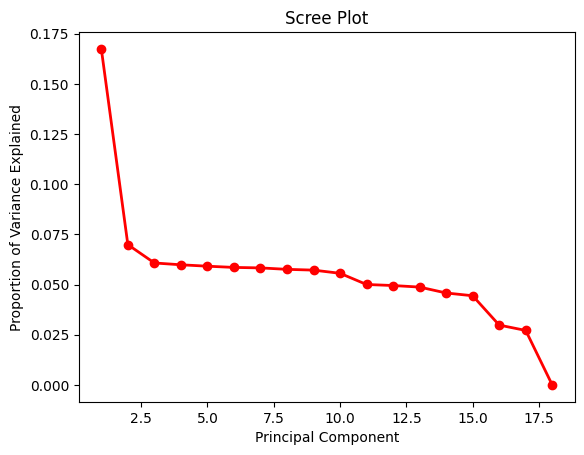


 Number of components to keep: 16


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Initialize a PCA object
pca = PCA()

# Fit the PCA object to the data
pca.fit(X_train)

# Create a scree plot
num_components = len(pca.explained_variance_ratio_)
plt.plot(np.arange(1, num_components+1), pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

# Determine the number of components to keep
variance_threshold = 0.95
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
num_components_to_keep = np.argmax(cumulative_variance_ratio >= variance_threshold) + 1

print(f'\n Number of components to keep: {num_components_to_keep}')

# Transform the data using the chosen number of components
pca = PCA(n_components=num_components_to_keep)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

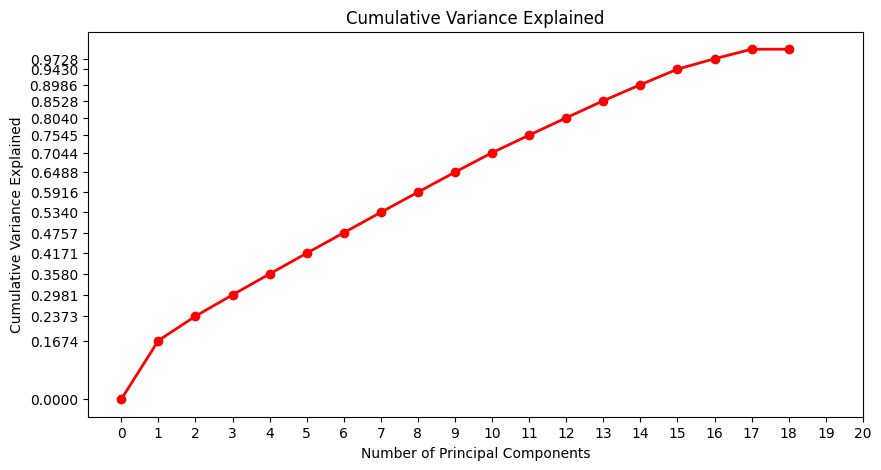

In [23]:
# Plot the cumulative variance explained

fig = plt.figure(figsize=(10, 5))

cum = np.insert(cumulative_variance_ratio, 0, 0)
ylab = np.insert(np.cumsum(pca.explained_variance_ratio_), 0, 0)

plt.plot(cum, 'ro-', linewidth=2)
plt.title('Cumulative Variance Explained')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.yticks(ylab)
plt.xticks(np.arange(0, 21))
plt.show()